In [ ]:
import numpy as np
import pickle, os
import matplotlib.pyplot as plt
from hyperparameters import *
from sliding_window import *
from clustering import *
from plotting import *
# from sliding_window_per_network import *
from scipy.stats import ttest_rel, ttest_ind
from stats import *

import warnings, numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all="ignore");

In [2]:
TR              = 0.80      # seconds, 800 ms
ROIs            = 216       # number of ROIs
win_len         = 56        # 30–50 TR (≈28–40 s, with TR=0.8s)
step            = 12        # = 1 otherwise: the higher the less autocorrelation
use_gaussian    = True      # False for rectangular sliding window
sigma           = None      # if None, sigma = win_len/3
fisher_z        = True      # False
vectorize       = True      # False
zscore          = True      # False
work_with_nets  = False     # True

In [3]:
# Identify Networks
roi_to_network, roi_net_masks, net_mask_names = load_roi_net_from_lut(
    yeo_atlas_path="atlas/Schaefer2018_200Parcels_17Networks_order_info.txt", # _pCun
    tian_atlas_path="atlas/Tian_Subcortex_S1_3T_label.txt",
    combine_networks=True)

# print("Networks:", roi_to_network)
print(f'Example: "Default Mode Network (DMN)" index: {net_mask_names["Default"]}')

Networks: ['AMY' 'CAU' 'Cont' 'Default' 'DorsAttn' 'GP' 'HIP' 'Limbic' 'NAc' 'PUT'
 'SalVentAttn' 'SomMot' 'TempPar' 'VisCent' 'VisPeri' 'aTH' 'pTH'], 17 unique networks.
Example: "Default Mode Network (DMN)" index: 3


### ToDo:
1. Usa `Baseline` invece di SHAM/REAL PRE; ✅
2. Approfondisci in letteratura;
3. Metastability analysis: che cos'è e approfondisci paper;
4. Includi `17Networks_LH_ContC_pCun_1`e `17Networks_LH_ContC_pCun_2`(LH e RH) nel DMN direttamente.

In [4]:
which_networks = [
    "Default",
    # "DorsAttn"
    "HIP"
]

In [5]:
# 1) Load timeseries
Data_folder = 'Data/'
BASELINE    = np.load(f'{Data_folder}/BASELINE_timeseries.npy') 
SHAM_PRE    = np.load(f'{Data_folder}/SHAM_timeseries_PRE.npy')
SHAM_POST   = np.load(f'{Data_folder}/SHAM_timeseries_POST.npy')
REAL_PRE    = np.load(f'{Data_folder}/non_SHAM_timeseries_PRE.npy')
REAL_POST   = np.load(f'{Data_folder}/non_SHAM_timeseries_POST.npy')

TimePoints = min(BASELINE.shape[1],SHAM_PRE.shape[1], SHAM_POST.shape[1], REAL_PRE.shape[1], REAL_POST.shape[1])

# 2) Optionally, select only specific networks
if work_with_nets and which_networks is not None:
    combined_mask = np.zeros(ROIs, dtype=bool)
    masks = [roi_net_masks[net_mask_names[n]] for n in which_networks]
    if len(masks) > 1:
        for mask in masks:
            combined_mask |= mask 
    else:
        combined_mask = masks[0]
else:
    combined_mask = np.ones(ROIs, dtype=bool)

BASELINE    = BASELINE[:, :TimePoints, combined_mask]
SHAM_PRE    = SHAM_PRE[:, :TimePoints, combined_mask]
SHAM_POST   = SHAM_POST[:, :TimePoints, combined_mask]
REAL_PRE    = REAL_PRE[:, :TimePoints, combined_mask]
REAL_POST   = REAL_POST[:, :TimePoints, combined_mask]

effective_ROIs = ROIs if not work_with_nets else int(np.sum(combined_mask))
Number_of_subjects = SHAM_PRE.shape[0]

N_windows = int((TimePoints - win_len)/step) + 1
print(f'{N_windows = }')

N_windows = 62


In [6]:
from bold_spectrum_analysis import (compute_psd_welch, compute_psd_fft,
                                    spectral_features, plot_spectrum, save_features_to_csv)
all_features = []
subject_labels = []

if not os.path.exists("out/spectrum/psd_welch_median_SHAM_PRE_0.png"):
    for ii in range(Number_of_subjects):
        # Welch
        f_w, P_w = compute_psd_welch(SHAM_PRE[ii], TR, nperseg=256, noverlap=192)
        feats = spectral_features(f_w, P_w)
        plot_spectrum(f_w, np.median(P_w, axis=0), title="Welch PSD (median across ROIs)",
                outpath=f"out/spectrum/psd_welch_median_SHAM_PRE_{ii}.png", log10=True, annotate_bands=True)

        # FFT diretto (più varianza, picchi immediati)
        f_f, P_f = compute_psd_fft(SHAM_PRE[ii], TR)
        plot_spectrum(f_f, np.median(P_f, axis=0), title="FFT spectrum (median across ROIs)",
                    outpath=f"out/spectrum/psd_fft_median_SHAM_PRE_{ii}.png", log10=True, annotate_bands=True)
        feats['subject'] = np.full(effective_ROIs, ii)
        all_features.append(feats)
    df = pd.concat([pd.DataFrame(feat) for feat in all_features], ignore_index=True)
    save_features_to_csv(df, "out/spectrum/features_all_subjects_SHAM_PRE.csv")

In [7]:
# 3) Compute static FC for reference of each condition
static_FC_baseline  = static_fc_for_condition(BASELINE,  zscore=zscore, fisher_z=fisher_z)
static_FC_sham_pre  = static_fc_for_condition(SHAM_PRE,  zscore=zscore, fisher_z=fisher_z)
static_FC_sham_post = static_fc_for_condition(SHAM_POST, zscore=zscore, fisher_z=fisher_z)
static_FC_real_pre  = static_fc_for_condition(REAL_PRE,  zscore=zscore, fisher_z=fisher_z)
static_FC_real_post = static_fc_for_condition(REAL_POST, zscore=zscore, fisher_z=fisher_z)

static_FC = {
    "BASELINE": static_FC_baseline,
    "SHAM_PRE":  static_FC_sham_pre,
    "SHAM_POST": static_FC_sham_post,
    "REAL_PRE":  static_FC_real_pre,
    "REAL_POST": static_FC_real_post
}

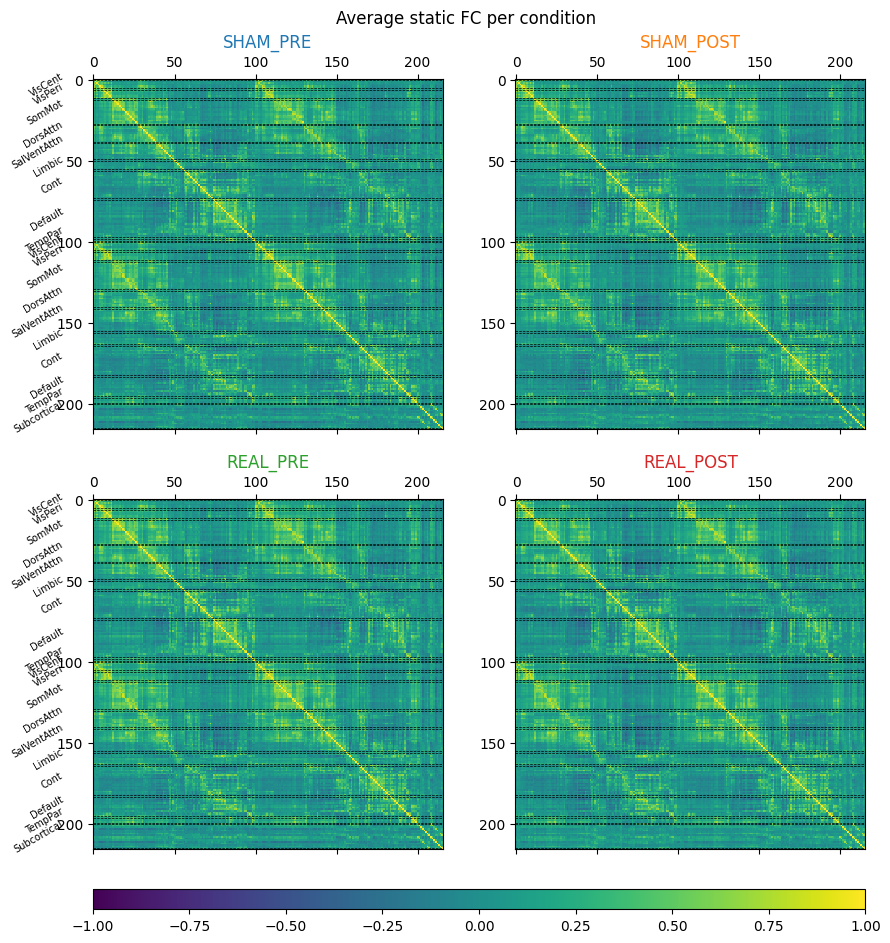

In [8]:
plot_mean_static_FC({key:val for jj, (key, val) in enumerate(static_FC.items()) if jj!=0}, 
                    roi_to_networks=roi_to_network[combined_mask])

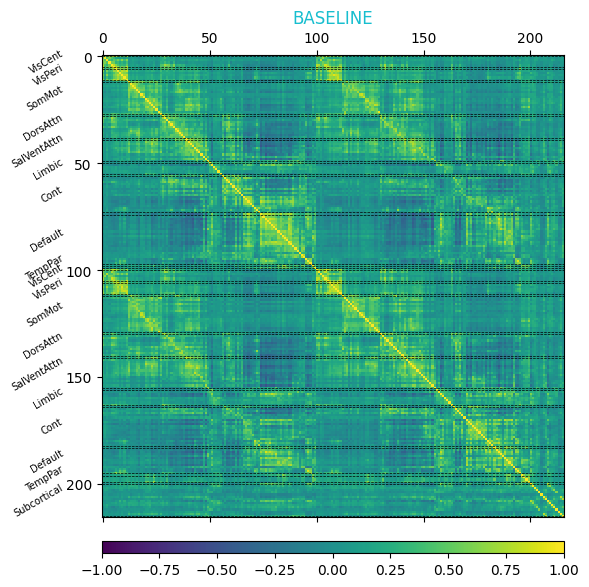

In [9]:
plot_mean_static_FC_single(static_FC['BASELINE'], roi_to_networks=roi_to_network[combined_mask])

In [10]:
r_k_sham, l2_k_sham, rbar_sham, l2_mean_sham = centroid_similarity_stats(
    [vec_upper(np.array(static_FC['BASELINE']).mean(axis=0))], 
    [vec_upper(np.array(static_FC['SHAM_POST']).mean(axis=0))], 
    K=1)
print(f'SHAM PRE vs POST:\n{rbar_sham = }\n{l2_mean_sham = }')
print(f'l2 distance per edge: {l2_mean_sham/(effective_ROIs*(effective_ROIs-1)/2):.4f}\n')

r_k_real, l2_k_real, rbar_real, l2_mean_real = centroid_similarity_stats(
    [vec_upper(np.array(static_FC['BASELINE']).mean(axis=0))], 
    [vec_upper(np.array(static_FC['REAL_POST']).mean(axis=0))], 
    K=1)
print(f'REAL PRE vs POST:\n{rbar_real = }\n{l2_mean_real = }')
print(f'l2 distance per edge: {l2_mean_real/(effective_ROIs*(effective_ROIs-1)/2):.4f}')

SHAM PRE vs POST:
rbar_sham = 0.9560813005616626
l2_mean_sham = 9.297259870100925
l2 distance per edge: 0.0004

REAL PRE vs POST:
rbar_real = 0.9561049517415698
l2_mean_real = 9.237892654947634
l2 distance per edge: 0.0004


In [11]:
# Paired comparison (same subjects) REAL_PRE vs REAL_POST, due sides, FDR 5%
df_edges, df_summary = ttests_edgewise(
    static_FC, "BASELINE", "REAL_POST", 
    paired=True, already_fisher_z=fisher_z, alpha=0.05, tail="two-sided",
    node_network=roi_to_network[combined_mask])

# df_edges: all pairs (i,j) with t, p, q, effect_size, ecc.
# Significant nodes after FDR:
sig_edges = df_edges[df_edges["q"] <= 0.05]

In [12]:
df_edges.head()

i    j         t         p  meanA(r)  meanB(r)  diff_mean  effect_size  \
0   76  158  6.045377  0.000017  0.784111  0.676758   0.107352     1.466219   
1   74   82  5.896442  0.000023  0.589263  0.435915   0.153348     1.430097   
2  170  188  5.639319  0.000037  0.788246  0.707505   0.080741     1.367736   
3   12  126 -5.595040  0.000040  0.602297  0.708466  -0.106169    -1.356997   
4   79   87  5.422925  0.000056  0.760234  0.653852   0.106382     1.315253   

          q    sig  t_pos    net_i    net_j           net_pair  
0  0.233698  False   True  Default   Limbic   Default — Limbic  
1  0.233698  False   True  Default  Default  Default — Default  
2  0.233698  False   True     Cont  Default     Cont — Default  
3  0.233698  False  False   SomMot   SomMot    SomMot — SomMot  
4  0.243919  False   True  Default  Default  Default — Default

In [13]:
# Aggregation per network pair: see where they change
df_summary.head()

net_pair  n_edges  n_sig  prop_sig  n_sig_pos  n_sig_neg  \
0       AMY — AMY        1      0       0.0          0          0   
1       AMY — CAU        4      0       0.0          0          0   
2      AMY — Cont       74      0       0.0          0          0   
3   AMY — Default       74      0       0.0          0          0   
4  AMY — DorsAttn       44      0       0.0          0          0   

   prop_sig_pos  prop_sig_neg  mean_effect  mean_diff    mean_t  
0           0.0           0.0     0.134736   0.022127  0.555532  
1           0.0           0.0     0.140526   0.027495  0.579402  
2           0.0           0.0     0.176624   0.030758  0.728241  
3           0.0           0.0     0.135115   0.029639  0.557095  
4           0.0           0.0    -0.023303  -0.006314 -0.096083

In [14]:
# 2) Compute dFC of each condition
swc_baseline = dfc_for_condition(
    BASELINE, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_sham_pre = dfc_for_condition(
    SHAM_PRE, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_sham_post = dfc_for_condition(
    SHAM_POST, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_real_pre = dfc_for_condition(
    REAL_PRE,
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z, 
    vectorize=vectorize,
    zscore=zscore
)

swc_real_post = dfc_for_condition(
    REAL_POST, 
    win_len=win_len, 
    step=step, 
    gaussian=use_gaussian, 
    sigma=sigma, 
    fisher_z=fisher_z,
    vectorize=vectorize,
    zscore=zscore
)

In [15]:
all_windows = True
total_windows = swc_sham_pre[0].shape[0]
number_of_windows = 5
assert number_of_windows <= swc_sham_pre[0].shape[0]
isolate_windows = total_windows if all_windows else number_of_windows

In [16]:
dfc_by_condition = {
    "SHAM_PRE": [subj[:isolate_windows, :] for subj in swc_sham_pre],
    "SHAM_POST": [subj[:isolate_windows, :] for subj in swc_sham_post],
    "REAL_PRE": [subj[:isolate_windows, :] for subj in swc_real_pre],
    "REAL_POST": [subj[:isolate_windows, :] for subj in swc_real_post],
    "BASELINE": [subj[:isolate_windows, :] for subj in swc_baseline]
}

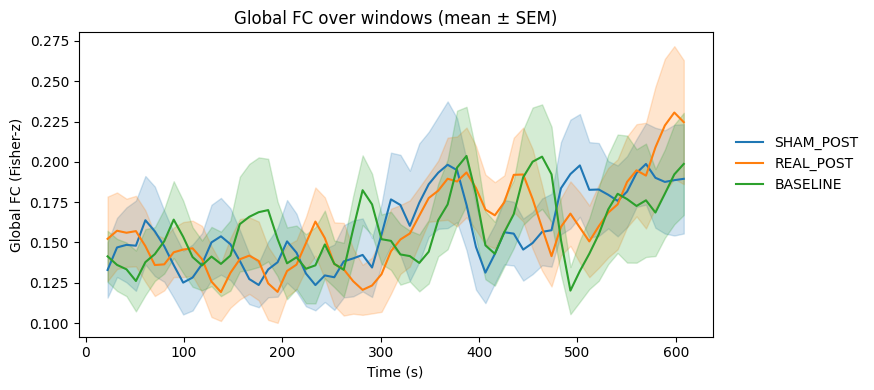

In [17]:
# 1) Global metric per subject:
#   - condition, subj, mu, sd, vol, slope
# series_by_cs, df_global = global_metrics_per_subject(dfc_by_condition)
# plot_global_series_mean_sem(series_by_cs, list(dfc_by_condition.keys()))
series_by_cs, df_global = global_metrics_per_subject(dfc_by_condition)
plot_global_series_mean_sem({key:val for key, val in series_by_cs.items() if 'PRE' not in key}, 
                            [key for key in dfc_by_condition.keys() if 'PRE' not in key],
                            step=step, win_len=win_len, TR=TR)

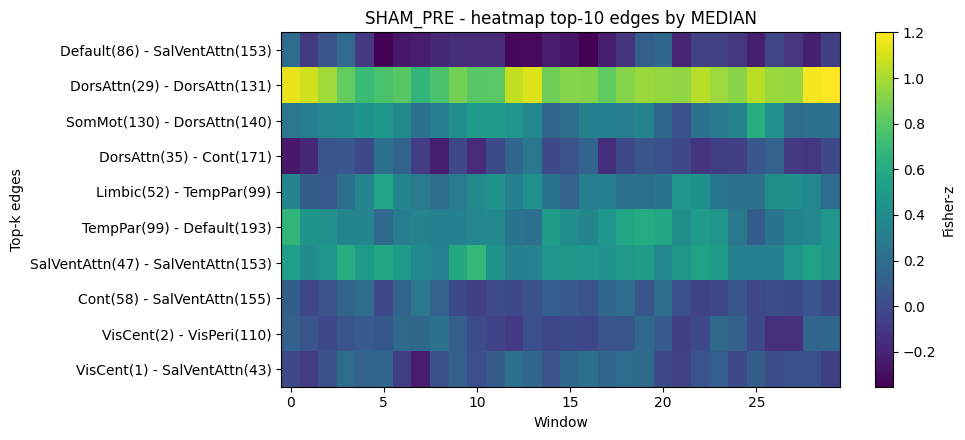

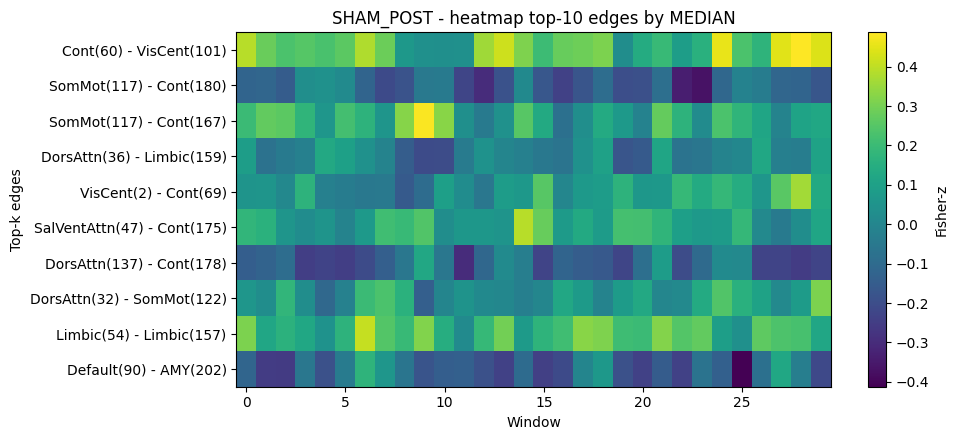

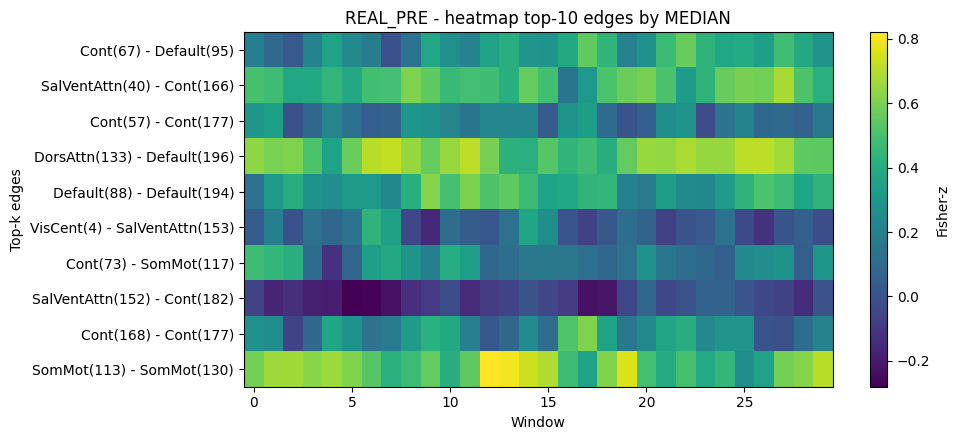

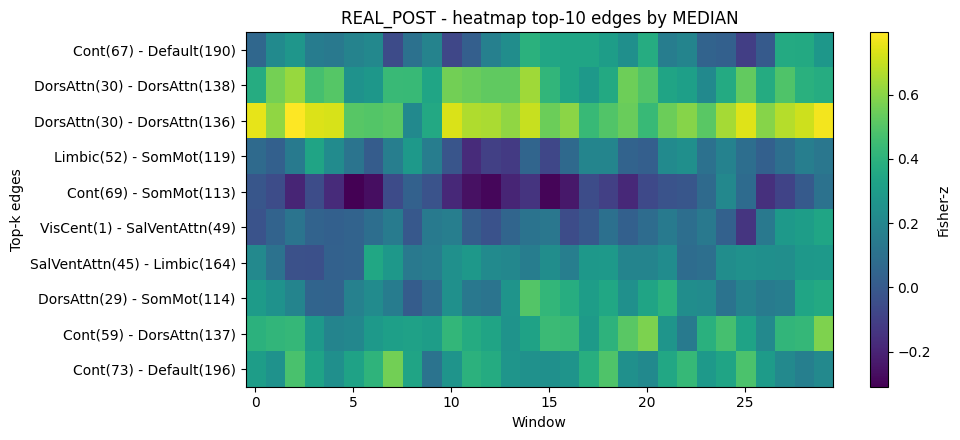

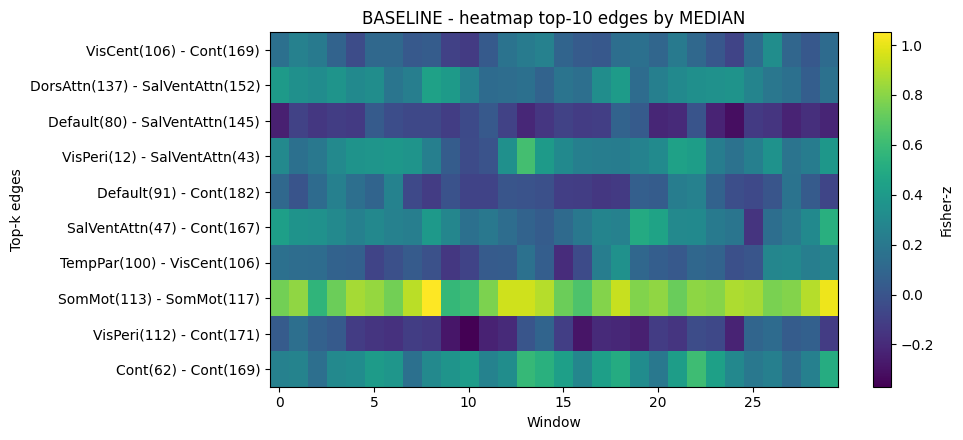

In [18]:
roi_roi_names = np.array([
    np.array([" - ".join((f'{netA}({i})', f'{netB}({j})')) for j, netB in enumerate(roi_to_network[combined_mask], start=1)
              ]) for i, netA in enumerate(roi_to_network[combined_mask], start=1)])
plot_topk_edge_heatmap(dfc_by_condition, cond='SHAM_PRE', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='SHAM_POST', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='REAL_PRE', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='REAL_POST', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)
plot_topk_edge_heatmap(dfc_by_condition, cond='BASELINE', metric='median',
                       roi_roi_names=vec_upper(roi_roi_names), k=10)

In [19]:
# 2.a) Build edge mask by pair of networks
networks_pair_masks, pairs = build_edge_masks_by_netpair(roi_net_masks, net_mask_names)
# 2.b) Metric per subject for each pair of networks 
if work_with_nets:
    base = np.zeros(effective_ROIs,dtype=np.bool)
    net1_net1 = np.zeros_like(base)
    net1_net1[:effective_ROIs-2] = True
    net1_net2 = np.ones_like(base)
    net2_net2 = np.zeros_like(base)
    net2_net2[effective_ROIs-2:] = True
    networks_pair_masks = {
        f'{which_networks[0]}-{which_networks[0]}':net1_net1,
        f'{which_networks[0]}-{which_networks[1]}':net1_net2,
        f'{which_networks[1]}-{which_networks[1]}':net2_net2
    }
    pairs = list(networks_pair_masks.keys())
series_by_cs_pair, df_metrics = netpair_metrics_per_subject(dfc_by_condition, roi_net_masks=None, net_mask_names=None, 
                                                            masks=networks_pair_masks)

df_metrics

condition  subj net_pair        mu        sd       vol     slope
0      SHAM_PRE     1  AMY-AMY  0.993827  0.405615  0.313538  0.016272
1      SHAM_PRE     2  AMY-AMY  0.901124  0.421598  0.277233  0.004118
2      SHAM_PRE     3  AMY-AMY  1.214000  0.502687  0.177725  0.021359
3      SHAM_PRE     4  AMY-AMY  1.260350  0.405873  0.272916  0.018958
4      SHAM_PRE     5  AMY-AMY  1.172030  0.540204  0.411150  0.008253
...         ...   ...      ...       ...       ...       ...       ...
13000  BASELINE    13  pTH-pTH  0.212463  0.402692  0.270764  0.020186
13001  BASELINE    14  pTH-pTH  0.387782  0.346209  0.158256  0.005644
13002  BASELINE    15  pTH-pTH  0.392801  0.444229  0.236230 -0.010640
13003  BASELINE    16  pTH-pTH  0.455163  0.422242  0.199182  0.002788
13004  BASELINE    17  pTH-pTH  0.610611  0.431337  0.359940 -0.022165

[13005 rows x 7 columns]

In [20]:
# df_metrics[np.logical_and(df_metrics['subj'] == 1, df_metrics['condition'] == 'SHAM_PRE')]

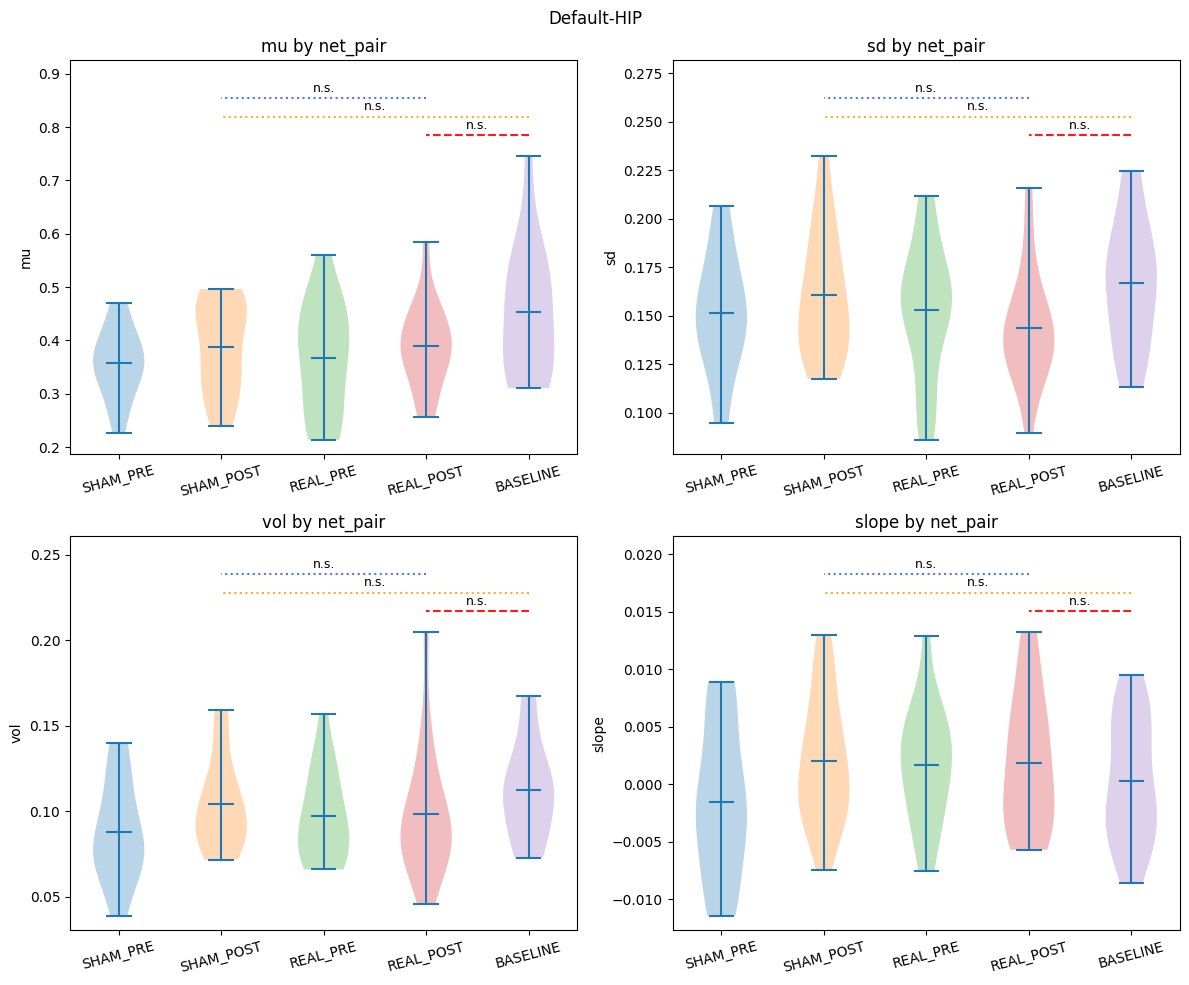

In [21]:
conds_all = ["BASELINE","REAL_POST","SHAM_POST"]
compare_pairs_all = list(combinations(conds_all, 2))
paired_pairs_only_prepost = [("BASELINE","REAL_POST"), ("BASELINE","SHAM_POST")]

connector_kwargs={
        ("BASELINE","REAL_POST"): {"ls":"--", "lw":1.5, "color":"red",      "alpha":0.9},
        ("BASELINE","SHAM_POST"): {"ls":":",  "lw":1.5, "color":"orange",   "alpha":0.9},
        ("REAL_POST","SHAM_POST"): {"ls":":", "lw":1.5, "color":"royalblue",   "alpha":0.9},
    }


fig, axarr = plt.subplots(2, 2, figsize=(12, 10))
plot_violin_metric_by_netpair(df_metrics, metric="mu", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost,
                              netpairs=['-'.join(which_networks)], ax_array=axarr[0, 0], fdr=True, connector_kwargs=connector_kwargs)
plot_violin_metric_by_netpair(df_metrics, metric="sd", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost, 
                              netpairs=['-'.join(which_networks)], ax_array=axarr[0, 1], fdr=True, connector_kwargs=connector_kwargs)
plot_violin_metric_by_netpair(df_metrics, metric="vol", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost, 
                              netpairs=['-'.join(which_networks)], ax_array=axarr[1, 0], fdr=True, connector_kwargs=connector_kwargs)
plot_violin_metric_by_netpair(df_metrics, metric="slope", compare_pairs=compare_pairs_all, paired_pairs=paired_pairs_only_prepost, 
                              netpairs=['-'.join(which_networks)], ax_array=axarr[1, 1], fdr=True, connector_kwargs=connector_kwargs)
plt.suptitle(f"{'-'.join(which_networks)}")
plt.tight_layout()
plt.show()

In [22]:
df_global

condition  subj        mu        sd       vol     slope
0   SHAM_PRE     1  0.311561  0.149980  0.103119 -0.000719
1   SHAM_PRE     2  0.099256  0.048181  0.025550  0.001077
2   SHAM_PRE     3  0.126228  0.074875  0.028312  0.004916
3   SHAM_PRE     4  0.160944  0.059575  0.032973 -0.003384
4   SHAM_PRE     5  0.123363  0.089920  0.034329 -0.001979
..       ...   ...       ...       ...       ...       ...
80  BASELINE    13  0.193786  0.059055  0.043735  0.000288
81  BASELINE    14  0.337747  0.158082  0.110008  0.010111
82  BASELINE    15  0.144227  0.094551  0.028282  0.004772
83  BASELINE    16  0.169226  0.059935  0.039028  0.000190
84  BASELINE    17  0.109621  0.051743  0.029762 -0.001198

[85 rows x 6 columns]

In [23]:
# 3) Paired tests PRE vs POST (REAL & SHAM)
df_paired_real = paired_tests_on_global(df_global, "BASELINE", "REAL_POST", test="ttest")   # test="wilcox"
df_paired_sham = paired_tests_on_global(df_global, "BASELINE", "SHAM_POST", test="ttest")   # test="wilcox"

In [24]:
df_paired_real

metric      stat         p     meanA     meanB      diff    sig
0     sd -0.891676  0.385780  0.069479  0.078896 -0.009417  False
1  slope -0.719449  0.482242  0.001367  0.002235 -0.000868  False
2    vol -0.190689  0.851168  0.045250  0.046832 -0.001582  False
3     mu -0.093034  0.927031  0.157706  0.159777 -0.002070  False

In [25]:
df_paired_sham

metric      stat         p     meanA     meanB      diff    sig
0  slope -0.699530  0.494266  0.001367  0.001915 -0.000548  False
1    vol  0.410915  0.686586  0.045250  0.042434  0.002816  False
2     sd  0.177873  0.861055  0.069479  0.067982  0.001496  False
3     mu -0.039528  0.968958  0.157706  0.158589 -0.000883  False

#### PRE e POST dello stesso soggetto non sono indipendenti (stessa persona, stesso cervello). Per questo si usa un modello “misto” (o, in versione semplice, un test appaiato sul delta). L’indipendenza c’è solo tra soggetti diversi (e tra gruppi SHAM/REAL, che sono tra-soggetti).

#### Quello che ti aspetti (“PRE simili tra gruppi e SHAM_POST simile ai PRE”) si traduce in: $\Delta SHAM \approx 0$ (placebo non cambia), vuoi verificare se $\Delta REAL \not\approx 0$ e soprattutto se $\Delta REAL$ è diverso da $\Delta SHAM$. L’interazione $TIME\times STIM$ testa esattamente $H_0: \Delta REAL = \Delta SHAM$.

In [26]:
# # 3) Mixed model REAL×TIME
# time_map = {"REAL_PRE":"PRE","REAL_POST":"POST","SHAM_PRE":"PRE","SHAM_POST":"POST"}
# stim_map = {"REAL_PRE":"REAL","REAL_POST":"REAL","SHAM_PRE":"SHAM","SHAM_POST":"SHAM"}
# df_long  = build_longform_for_mixed(df_global, time_map, stim_map)
# res_mu   = fit_mixed_interaction(df_long, "mu")
# res_mu.summary()    # look at TIME:POST:STIM:REAL for the interaction:
#                     # the POST-PRE change in REALs minus the POST-PRE change in SHAMs. 
#                     # This is exactly "the effect of the stimulation net of the changes already made in the control.

#### Coef = −0.035 → l’interazione è negativa: il cambiamento POST-PRE nei REAL è 0.035 unità più piccolo del cambiamento negli SHAM (per quella metrica).
#### Std Err = 0.035 → incertezza della stima.
#### z = −0.994 → statistica di Wald.
#### p = 0.320 → non significativo a 0.05.
#### CI 95% = [−0.105, 0.034] → comprende 0 → coerente con non significatività.

In [27]:
for b, x, y, z, w in zip(swc_baseline, swc_sham_pre, swc_sham_post, swc_real_pre, swc_real_post):
    print(b.shape, x.shape, y.shape, z.shape, w.shape)
    break

(30, 23220) (30, 23220) (30, 23220) (30, 23220) (30, 23220)


Loading PCA from file...


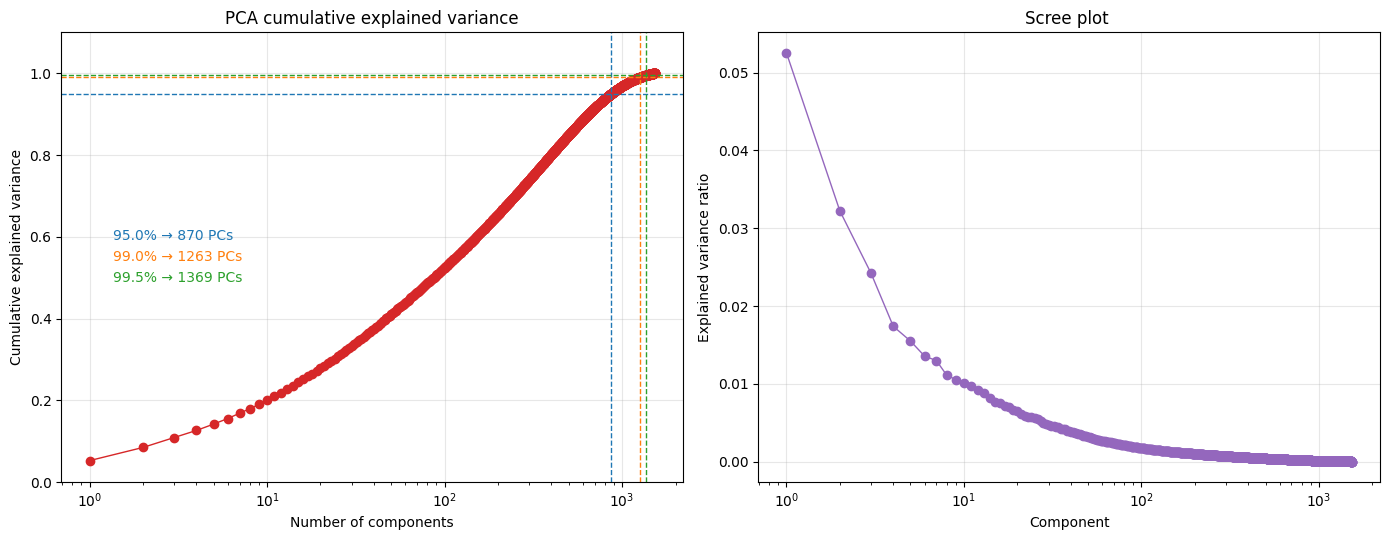

Suggested PCs: {0.95: 870, 0.99: 1263, 0.995: 1369}


In [28]:
# 2.a) Choose number of PCs to retain
all_for_fit = swc_baseline + swc_sham_post + swc_real_post
X = np.concatenate(all_for_fit, axis=0)
# all_for_fit = [x - vec_upper(np.array(static_FC['SHAM_PRE']).mean(axis=0)) for x in swc_sham_pre] + [x - vec_upper(np.array(static_FC['SHAM_POST']).mean(axis=0)) for x in swc_sham_post] +\
#     [x - vec_upper(np.array(static_FC['REAL_PRE']).mean(axis=0)) for x in swc_real_pre] + [x - vec_upper(np.array(static_FC['REAL_POST']).mean(axis=0)) for x in swc_real_post]
# X = np.concatenate(all_for_fit, axis=0)

fileName_PCA = f"meta/pca_sel-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_baseline.pkl"

if os.path.exists(fileName_PCA):
    with open(fileName_PCA, 'rb') as f:
        pca_sel = pickle.load(f)
    print("Loading PCA from file...")
    plot_cumulative_variance(pca_sel['cumvar'], pca_sel['targets'], pca_sel['pca'], X)
else:
    pca_sel = choose_pca_components(
        X=X,
        var_targets=(0.95, 0.99, 0.995), 
        whiten=False, fast_pca=False,
        max_samples=30000, max_components=5000,
        center=True, randomized=True, random_state=0, 
        show_plot=True
    )
    with open(fileName_PCA, "wb") as f:
        pickle.dump(pca_sel, f)
    
print("Suggested PCs:", pca_sel["targets"])   # es. {0.95: 38, 0.99: 92}
pca_for_metric = pca_sel["pca"]

Loading K-means selection from file...


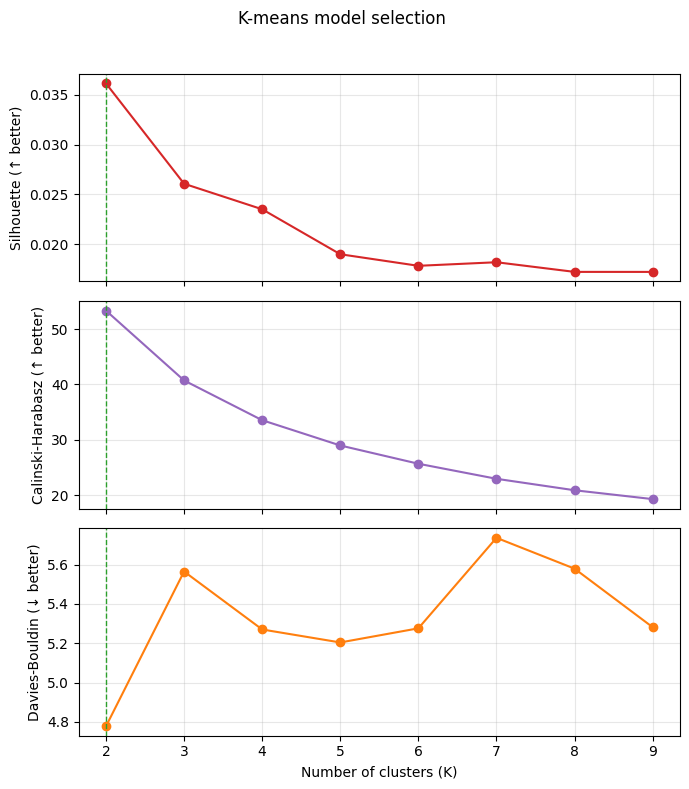

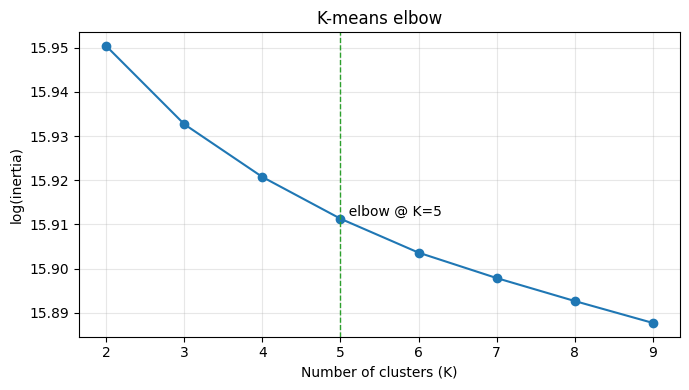

Best K by Silhouette: 2
Best K by Calinski-Harabasz: 2
Best K by Davies-Bouldin: 2


In [29]:
# 2.b) Choose K with K-means (k selection)
L1_norm_for_metric = False
fileName_kmeans = f"meta/k_sel-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_baseline.pkl"

if os.path.exists(fileName_kmeans):
    with open(fileName_kmeans, 'rb') as f:
        k_sel = pickle.load(f)
    print("Loading K-means selection from file...")
    plot_k_selection(
        k_sel["Ks"], k_sel["sils"], k_sel["chs"], k_sel["dbs"], 
        k_sel["best_k_sil"], X, fast_k_means=False
    )
    plot_elbow(
        k_sel["Ks"], k_sel["inertias"], 
        best_k=k_sel["best_k_elbow"], logy=True
    )
else:
    k_sel = kmeans_k_selection(
        X=X,
        k_min=2, k_max=9,
        center=True,
        pca_for_metric=pca_for_metric,      # use the same PCA space to fit for Silhouette/CH/Davies–Bouldin
        L1_norm_for_metric=L1_norm_for_metric,
        static_FC=np.concatenate(list(static_FC.values()), axis=0),
        win_len_per_subj=(TimePoints-win_len)//step +1,
        sample_for_k=20000, ROIs=effective_ROIs,
        n_pcs=pca_sel["targets"][0.99],    # or 0.95, 0.99
        n_init=150, fast_k_means=False,
        random_state=0, show_plot=True
    )
    with open(fileName_kmeans, "wb") as f:
        pickle.dump(k_sel, f)

print("Best K by Silhouette:", k_sel["best_k_sil"])
print("Best K by Calinski-Harabasz:", k_sel["best_k_ch"])
print("Best K by Davies-Bouldin:", k_sel["best_k_db"])

In [30]:
# 3) Fit PCA+k-means on all dFC (concatenated over subjects and conditions)
fileName_kmeans_on_dfc = f"meta/fit_kmeans_on_dfc-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_baseline.pkl"

k_number_of_states = min(k_sel['best_k_sil'], k_sel['best_k_ch'], k_sel['best_k_db'], k_sel['best_k_elbow'])
print(f'{k_number_of_states = }')

if os.path.exists(fileName_kmeans_on_dfc):
    with open(fileName_kmeans_on_dfc, 'rb') as f:
        k_on_dfc = pickle.load(f)
    pca, km, global_mean = k_on_dfc['pca'], k_on_dfc['km'], k_on_dfc['global_mean']
    print("Loading K-means selection from file...")
else:
    n_components = pca_sel['targets'][0.95]
    pca, km, global_mean = fit_kmeans_on_dfc(all_for_fit, 
                                            n_components=n_components, 
                                            k=k_number_of_states, 
                                            random_state=0)
    with open(fileName_kmeans_on_dfc, "wb") as f:
        pickle.dump({
            "pca":pca, 
            "km": km,
            "global_mean": global_mean
        }, f)

k_number_of_states = 2
Loading K-means selection from file...


In [31]:
# 4) Assign states and compute metrics for each condition
def metrics_for_condition(dfc_list, pca, km, global_mean):
    """
    dfc_list: list of dfc arrays (W,E) or (W,N,N) for all subjects in a condition
    Returns:
      occ_stack:   (n_subj, K)
      dwell_stack: (n_subj, K)
      trans_stack: (n_subj, K, K)
    """
    all_occ, all_dwell, all_run_lengths, all_trans_mats = [], [], [], []
    K = km.n_clusters # <- get K from the k-means model
    all_labels = []
    
    for dfc_vec in dfc_list:
        labels = predict_states(dfc_vec, pca, km, global_mean)
        all_labels.append(labels)
        occ, dwell, run_lengths, trans = state_metrics(labels, K=K)  # (K,), (K,), (K,K)
        all_occ.append(occ)
        all_dwell.append(dwell)
        all_run_lengths.append(run_lengths)
        all_trans_mats.append(trans)

    occ_stack   = np.vstack(all_occ)
    dwell_stack = np.vstack(all_dwell)
    trans_stack = np.stack(all_trans_mats, axis=0)
    all_labels  = np.vstack(all_labels)
    return occ_stack, dwell_stack, all_run_lengths, trans_stack, all_labels

In [32]:
occ_BASELINE,   dwell_BASELINE,  run_length_BASELINE,  trans_BASELINE,  labels_BASELINE  = metrics_for_condition(swc_baseline, pca, km, global_mean)
occ_SHAM_POST,  dwell_SHAM_POST, run_length_SHAM_POST, trans_SHAM_POST, labels_SHAM_POST = metrics_for_condition(swc_sham_post, pca, km, global_mean)
occ_REAL_POST,  dwell_REAL_POST, run_length_REAL_POST, trans_REAL_POST, labels_REAL_POST = metrics_for_condition(swc_real_post, pca, km, global_mean)

In [33]:
# 5) Example of statistics: Mann-Whitney U test on occupancy of state 0
df_occ_REAL = compare_state_metrics(
    {"BASELINE": occ_BASELINE, "REAL_POST": occ_REAL_POST}, 
    "BASELINE", "REAL_POST",
    paired=True, test='ttest', alpha=0.05)
df_dwell_REAL = compare_state_metrics(
    {"BASELINE": dwell_BASELINE, "REAL_POST": dwell_REAL_POST}, 
    "BASELINE", "REAL_POST",
    paired=True, test='wilcoxon', alpha=0.05)

In [34]:
df_occ_REAL

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      0  0.770588  0.686275   0.084314  1.307314  0.209582      0.31707   
1      1  0.229412  0.313725  -0.084314 -1.307314  0.209582     -0.31707   

          q    sig  
0  0.209582  False  
1  0.209582  False

In [35]:
df_dwell_REAL

state      meanA     meanB  diff_mean     W         p  effect_size  \
0      0  13.557843  9.272549   4.285294  53.5  0.276185    -0.300654   
1      1   2.278431  2.436835  -0.158403  47.0  0.277128    -0.308824   

          q    sig  
0  0.277128  False  
1  0.277128  False

In [36]:
df_occ_SHAM = compare_state_metrics(
    {"BASELINE": occ_BASELINE, "SHAM_POST": occ_SHAM_POST}, 
    "BASELINE", "SHAM_POST",
    paired=True, test='ttest', alpha=0.05)
df_dwell_SHAM = compare_state_metrics(
    {"BASELINE": dwell_BASELINE, "SHAM_POST": dwell_SHAM_POST}, 
    "BASELINE", "SHAM_POST",
    paired=True, test='wilcoxon', alpha=0.05)

In [37]:
df_occ_SHAM

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      0  0.770588  0.703922   0.066667  0.860312  0.402325     0.208656   
1      1  0.229412  0.296078  -0.066667 -0.860312  0.402325    -0.208656   

          q    sig  
0  0.402325  False  
1  0.402325  False

In [38]:
df_dwell_SHAM

state      meanA      meanB  diff_mean     W         p  effect_size  \
0      0  13.557843  10.140196   3.417647  61.0  0.487381    -0.202614   
1      1   2.278431   2.954902  -0.676471  60.0  0.679014    -0.117647   

          q    sig  
0  0.679014  False  
1  0.679014  False

In [39]:
# 6) Example of statistics: compare delta occupancy REAL vs SHAM
df_occ_DELTA = compare_state_metrics(
    {"REAL": occ_BASELINE-occ_REAL_POST, "SHAM": occ_BASELINE-occ_SHAM_POST}, 
    "REAL", "SHAM",
    paired=False, test='ttest', alpha=0.05)
df_dwell_DELTA = compare_state_metrics(
    {"REAL": dwell_BASELINE-dwell_REAL_POST, "SHAM": dwell_BASELINE-dwell_SHAM_POST}, 
    "REAL", "SHAM",
    paired=False, test='wilcoxon', alpha=0.05)

In [40]:
df_occ_DELTA

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      0  0.084314  0.066667   0.017647  0.175038  0.862189     0.058619   
1      1 -0.084314 -0.066667  -0.017647 -0.175038  0.862189    -0.058619   

          q    sig  
0  0.862189  False  
1  0.862189  False

In [41]:
df_dwell_DELTA

state     meanA     meanB  diff_mean         t         p  effect_size  \
0      1 -0.158403 -0.676471   0.518067  0.489621  0.628509     0.163971   
1      0  4.285294  3.417647   0.867647  0.163333  0.871296     0.054700   

          q    sig  
0  0.871296  False  
1  0.871296  False

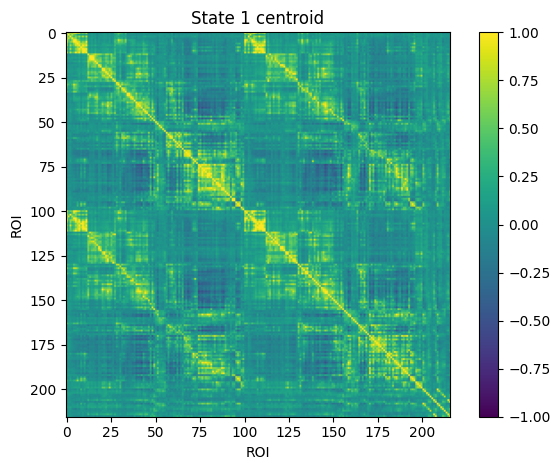

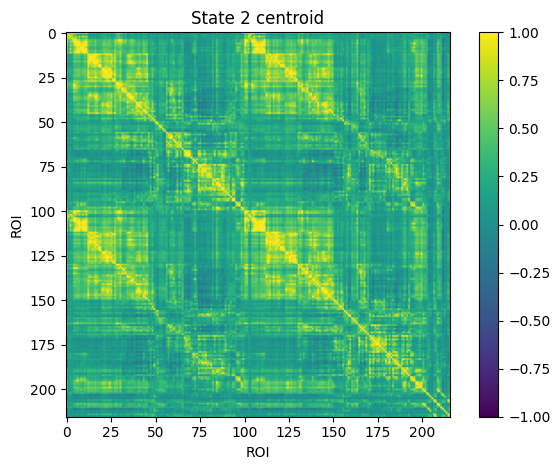

In [42]:
# ----- PLotting results -----
# 1) Centroids (needs your kmeans, pca, global_mean, and number of ROIs)
plot_state_centroids(km, pca, global_mean, n_rois=effective_ROIs, vmin=-1, vmax=1)

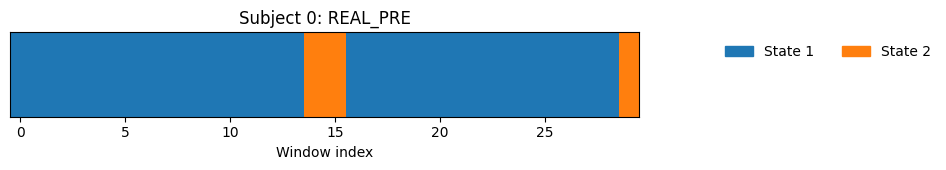

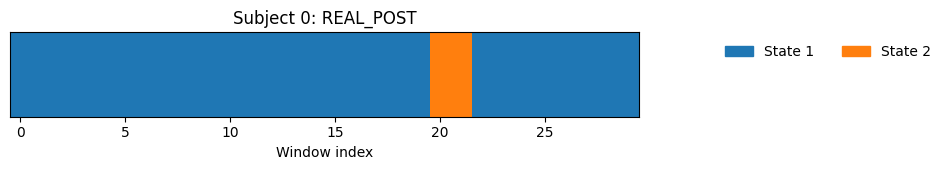

In [43]:
# 2) Barcode for one subject
subj_idx = 0
dfc_vec_pre = swc_baseline[subj_idx]       # shape (W, E) for subject 0
labels_subject0_pre = predict_states(dfc_vec_pre, pca, km, global_mean)  # shape (W,)
plot_state_barcode(labels_subject0_pre, title="Subject 0: REAL_PRE")
dfc_vec_post = swc_real_post[subj_idx]       # shape (W, E) for subject 0
labels_subject0_post = predict_states(dfc_vec_post, pca, km, global_mean)  # shape (W,)
plot_state_barcode(labels_subject0_post, title="Subject 0: REAL_POST")
# barcode_plots(labels_subject0, title="State sequence (Subject 0, REAL_POST)")

In [44]:
order = ["BASELINE","SHAM_POST","REAL_POST"]

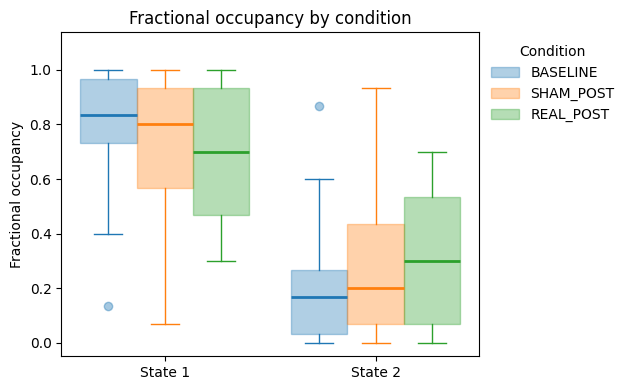

In [45]:
# 3) Fractional occupancy (dict of condition -> (n_subj, K))
occ_dict = {"BASELINE": occ_BASELINE, "SHAM_POST": occ_SHAM_POST,
            "REAL_POST": occ_REAL_POST}
sig_df_map_occ = {
    ("BASELINE","REAL_POST"): df_occ_REAL,
    ("BASELINE","SHAM_POST"): df_occ_SHAM,
}
plot_fractional_occupancy_boxplots(occ_dict, order=order, 
                                   sig_df=df_occ_REAL, alpha=0.05,
                                   cond_pairs=[("BASELINE","REAL_POST"), ("BASELINE","SHAM_POST")],
                                   sig_df_map=sig_df_map_occ,
                                   connector_kwargs={
                                       ("BASELINE","REAL_POST"): {"linestyle":"--", "linewidth":1.5, "color":"k", "alpha":0.9},
                                       ("BASELINE","SHAM_POST"): {"linestyle":":",  "linewidth":1.5, "color":"gray", "alpha":0.9},
                                       })

In [46]:
# alpha = 0.05
# K = next(iter(occ_dict.values())).shape[1]
# print((df_occ_REAL['q'] <= alpha).sum())  # quante righe significanti
# print(((df_occ_REAL['q'] <= alpha) & df_occ_REAL['state'].between(0, K-1)).sum())  # quante valide per il plo

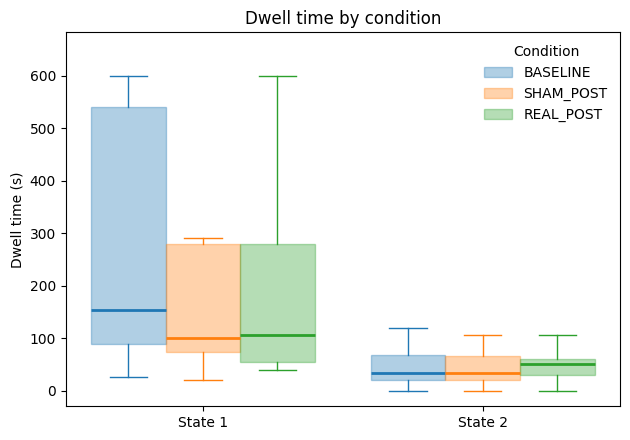

In [47]:
# 4) Dwell time
dwell_dict = {"BASELINE": dwell_BASELINE, "SHAM_POST": dwell_SHAM_POST,
              "BASELINE": dwell_BASELINE, "REAL_POST": dwell_REAL_POST}
sig_df_map_dwell = {
    ("BASELINE","REAL_POST"): df_dwell_REAL,
    ("BASELINE","SHAM_POST"): df_dwell_SHAM,
}

dwell_dict_sec = {
    key: val* step * TR for key, val in dwell_dict.items()
    }
plot_dwell_time_boxplots(dwell_dict_sec, in_seconds=True, order=order, showfliers=False,  # or True if you've converted
                         cond_pairs=[("BASELINE","REAL_POST"), ("BASELINE","SHAM_POST")],
                         sig_df_map=sig_df_map_dwell, alpha=0.05)

In [48]:
# # 5) Transition matrices
# trans_dict = {
#     "SHAM_PRE":     trans_SHAM_PRE,     # list of (K,K) per subject
#     "SHAM_POST":    trans_SHAM_POST,
#     "REAL_PRE":     trans_REAL_PRE,
#     "REAL_POST":    trans_REAL_POST,
# }
# plot_transition_matrices_by_condition(
#     trans_by_condition=trans_dict,
#     order=order,
#     colors=None,
#     cmap="viridis",
#     vmin=0.0, vmax=1.1,
#     annotate=False,
#     set_diag_zero=False,
#     suptitle="Average transition probabilities per condition"
# )

In [49]:
# # Or a single one:
# Tavg = average_transition_matrix(trans_SHAM_PRE)
# plot_transition_matrix(Tavg, cmap="magma", set_diag_zero=False, title="SHAM_PRE: average transitions")

In [50]:
# 6) Assign states and compute metrics for each subject, then save to file
def metrics_for_condition_full_save(dfc_list, pca, km, global_mean, step=step, TR=TR, file_name=None):
    """
    dfc_list: list of dfc arrays (W,E) or (W,N,N) for all subjects in a condition
    Returns:
      occ_stack:   (n_subj, K)
      dwell_stack: (n_subj, K)
      trans_stack: (n_subj, K, K)
    """
    K = km.n_clusters  # <- get K from the k-means model

    for kk, dfc_vec in enumerate(dfc_list):
        labels = predict_states(dfc_vec, pca, km, global_mean)
        out = state_metrics_full(labels, K=K, step=step, TR=TR)

        if file_name is not None:
            np.savez_compressed(
                f"{file_name}_subj{kk+1}.npz",
                occupancy=out["occupancy"],
                n_runs=out["n_runs"],
                mean_dwell=out["mean_dwell"],
                median_dwell=out["median_dwell"],
                trans_counts=out["trans_counts"],
                trans_matrix=out["trans_matrix"],
                dwell_from_Pkk=out["dwell_from_Pkk"],
                run_lengths=np.array([np.array(rl, dtype=int) for rl in out["run_lengths"]], dtype=object)
            )

In [51]:
all_labels = np.concatenate([predict_states(dfc, pca, km, global_mean) for dfc in all_for_fit])
win_cond = np.concat([[ord]*arr[0].shape[0]*len(arr) for ord, arr in zip(order, [swc_baseline, swc_sham_post, swc_real_post])])

In [52]:
centroids_by_cond = centroid_per_condition_state(X_vec=X, labels=all_labels, cond_of_win=win_cond, K=k_number_of_states)

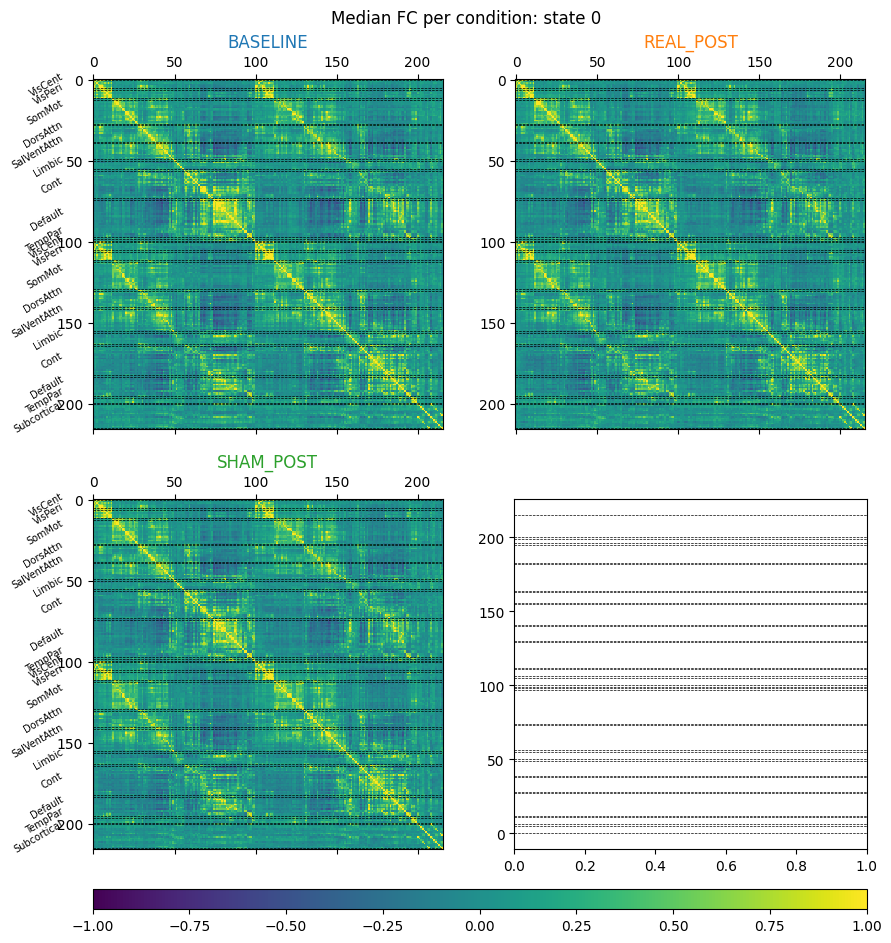

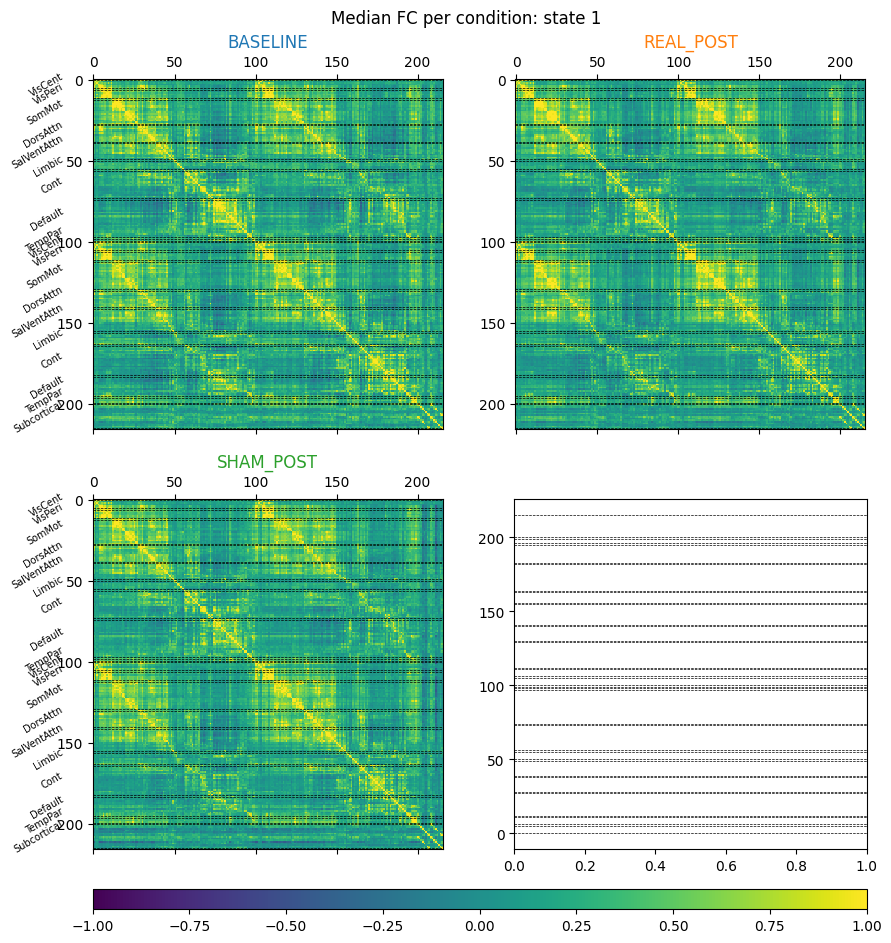

In [53]:
for state in range(k_number_of_states):
    plot_4_conditions({key: vec_to_matrix(val[state], N=effective_ROIs) for key, val in centroids_by_cond.items()},
                      roi_to_networks=roi_to_network[combined_mask], title=f'Median FC per condition: state {state}')

In [55]:
r_k_sham, l2_k_sham, zbar_sham, l2_mean_sham = centroid_similarity_stats(
    centroids_by_cond['BASELINE'], 
    centroids_by_cond['SHAM_POST'], 
    K=k_number_of_states)
print('SHAM PRE vs POST:')
for k in range(k_number_of_states):
    print(f'State {k}:\nrbar = {r_k_sham[k]}\nl2 = {l2_k_sham[k]}')

r_k_real, l2_k_real, zbar_real, l2_mean_real = centroid_similarity_stats(
    centroids_by_cond['BASELINE'], 
    centroids_by_cond['REAL_POST'], 
    K=k_number_of_states)
print('\nREAL PRE vs POST:')
for k in range(k_number_of_states):
    print(f'State {k}:\nrbar = {r_k_real[k]}\nl2 = {l2_k_real[k]}')

SHAM PRE vs POST:
State 0:
rbar = 0.9471096843665828
l2 = 11.077211485118458
State 1:
rbar = 0.883989883869593
l2 = 16.40158632700994

REAL PRE vs POST:
State 0:
rbar = 0.9485505103925878
l2 = 10.885573629289112
State 1:
rbar = 0.9041750671311509
l2 = 15.02059352228338


In [ ]:
# SHAM PRE vs POST
fileName_state_distance_SHAM = f"meta/state_distance-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_BASELINE_SHAM_POST.pkl"
if os.path.exists(fileName_state_distance_SHAM):
    with open(fileName_state_distance_SHAM, 'rb') as f:
        d_SHAM = pickle.load(f)
    print("Loading from file...")

else:
    d_within_BASELINE, d_within_SHAM_POST, d_SHAM_PRE_POST = [], [], []
    for k in range(k_number_of_states):
        d_within_BASELINE_k, d_within_SHAM_POST_k, d_SHAM_PRE_POST_k, _, _ = state_distance_distributions(X_vec=X, labels=all_labels, cond_of_win=win_cond, 
                                                                                                          condA='BASELINE', condB='SHAM_POST', 
                                                                                                          k=k, metric='euclidean')
        d_within_BASELINE.append(d_within_BASELINE_k)
        d_within_SHAM_POST.append(d_within_SHAM_POST_k)
        d_SHAM_PRE_POST.append(d_SHAM_PRE_POST_k)
    
    d_SHAM = {
        'BASELINE':  {k:dis for k, dis in zip(range(k_number_of_states), d_within_BASELINE)},
        'SHAM_POST': {k:dis for k, dis in zip(range(k_number_of_states), d_within_SHAM_POST)},
        'PRE-POST':  {k:dis for k, dis in zip(range(k_number_of_states), d_SHAM_PRE_POST)}
    }
    
    with open(fileName_state_distance_SHAM, "wb") as f:
        pickle.dump(d_SHAM, f)
 

p_value_SHAM = {
    f'State {k}':cohens_d(d_SHAM['BASELINE'][k], d_SHAM['SHAM_POST'][k])\
        for k in range(k_number_of_states)
    }
print(f'{p_value_SHAM = }')

for k in range(k_number_of_states):
    plot_state_distance_distributions(d_SHAM['BASELINE'][k], d_SHAM['SHAM_POST'][k], d_SHAM['PRE-POST'][k],
                                      labels=(f"Within BASELINE", "Within SHAM_POST", "Cross PRE-POST"),
                                      title=f"Window-to-window distance distributions for one state {k+1}")

p_value_REAL = {'State 0': np.float64(-0.007480507097692075), 'State 1': np.float64(0.05481212931979376)}


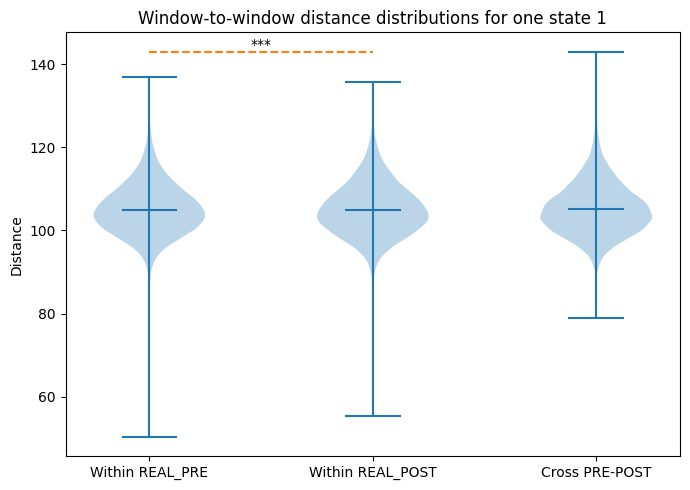

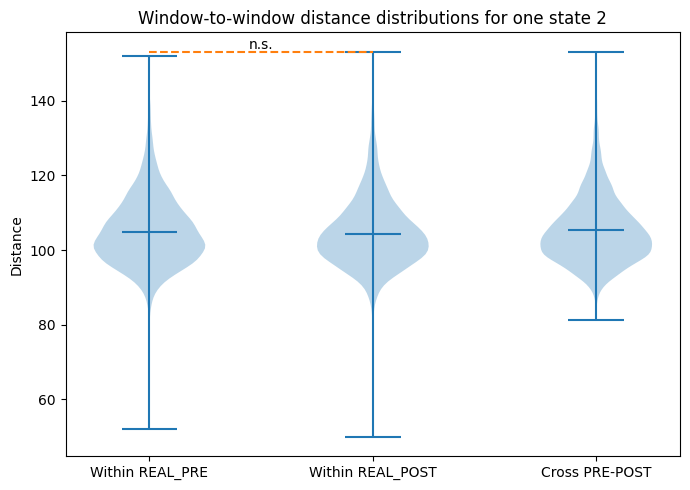

In [ ]:
# Real Pre vs Real Post
fileName_state_distance_REAL = f"meta/state_distance-step_{step}-win_len_{win_len}-gauss_{'T' if use_gaussian else 'F'}-\
fischer_{'T' if fisher_z else 'F'}-zscore_{'T' if zscore else 'F'}-\
{'L1_norm_for_metric' if L1_norm_for_metric else 'PCA_for_metric'}-\
work_with_nets_{'T' if work_with_nets else 'F'}_BASELINE_REAL_POST.pkl"
if os.path.exists(fileName_state_distance_REAL):
    with open(fileName_state_distance_REAL, 'rb') as f:
        d_REAL = pickle.load(f)
    print("Loading from file...")

else:
    d_within_BASELINE, d_within_REAL_POST, d_REAL_PRE_POST = [], [], []
    for k in range(k_number_of_states):
        d_within_BASELINE_k, d_within_REAL_POST_k, d_REAL_PRE_POST_k, _, _ = state_distance_distributions(X_vec=X, labels=all_labels, cond_of_win=win_cond,
                                                                                                          condA='BASELINE', condB='REAL_POST',
                                                                                                          k=k, metric='euclidean')
        d_within_BASELINE.append(d_within_BASELINE_k)
        d_within_REAL_POST.append(d_within_REAL_POST_k)
        d_REAL_PRE_POST.append(d_REAL_PRE_POST_k)
    
    d_REAL = {
        'REAL_PRE':  {k:dis for k, dis in zip(range(k_number_of_states), d_within_BASELINE)},
        'REAL_POST': {k:dis for k, dis in zip(range(k_number_of_states), d_within_REAL_POST)},
        'PRE-POST':  {k:dis for k, dis in zip(range(k_number_of_states), d_REAL_PRE_POST)}
    }
    
    with open(fileName_state_distance_REAL, "wb") as f:
        pickle.dump(d_REAL, f)
        
p_value_REAL = {
    f'State {k}':cohens_d(d_REAL['BASELINE'][k], d_REAL['REAL_POST'][k])\
        for k in range(k_number_of_states)
    }
print(f'{p_value_REAL = }')

for k in range(k_number_of_states):
    plot_state_distance_distributions(d_REAL['BASELINE'][k], d_REAL['REAL_POST'][k], d_REAL['PRE-POST'][k],
                                      labels=(f"Within BASELINE", "Within REAL_POST", "Cross PRE-POST"),
                                      title=f"Window-to-window distance distributions for one state {k+1}")